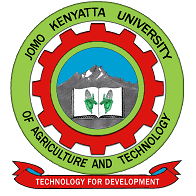

## Integrated Project: Understanding the yield


In this coding challenge, we will apply all of the skills we learned in regression.

⚠️ **Note that this code challenge is graded and will contribute to your overall marks. Submit this notebook for grading.**

# Introduction to simple linear regression

Simple linear regression is a fundamental statistical method used to quantify the relationship between two variables. It allows us to predict an outcome (dependent variable) based on the value of one predictor (independent variable). In this challenge, we will apply simple linear regression to understand how different environmental factors affect the standardised yield of crops.

Our insights will not only help local farmers maximise their harvests but also contribute to the sustainable agriculture practices in Maji Ndogo.



# Initial data exploration

Before we sow the seeds of our regression model, we need to get to know our soil – the dataset. This dataset was developed through extensive agricultural surveys conducted at farms across farm survey. It contains various factors that might influence a farm's crop yield, from the elevation of the fields to the average temperature they bask in.

Spend some time looking at the data dictionary and start thinking about what could be influencing our crop yield.

# Data dictionary

**1. Geographic features**

- **Field_ID:** A unique identifier for each field (BigInt).

- **Elevation:** The elevation of the field above sea level in metres (Float).

- **Latitude:** Geographical latitude of the field in degrees (Float). (DUMMY VARIABLE- the simulation might have created a relationship)

- **Longitude:** Geographical longitude of the field in degrees (Float). (DUMMY VARIABLE- the simulation might have created a relationship)

- **Location:** Province the field is in (Text).

- **Slope:** The slope of the land in the field (Float).

**2. Weather features**

- **Rainfall:** Amount of rainfall in the area in mm (Float).

- **Min_temperature_C:** Average minimum temperature recorded in Celsius (Float).(DUMMY VARIABLE)

- **Max_temperature_C:** Average maximum temperature recorded in Celsius (Float).(DUMMY VARIABLE)

- **Ave_temps:** Average temperature in Celcius (Float).

**3. Soil and crop features**

- **Soil_fertility:** A measure of soil fertility where 0 is infertile soil, and 1 is very fertile soil (Float).

- **Soil_type:** Type of soil present in the field (Text).

- **pH:** pH level of the soil, which is a measure of how acidic/basic the soil is (Float).

**4. Farm management features**

- **Field_ID:** Corresponding field identifier (BigInt).

- **Pollution_level:** Level of pollution in the area where 0 is unpolluted and 1 is very polluted (Float).

- **Plot_size:** Size of the plot in the field (Ha) (Float). (DUMMY VARIABLE)

- **Chosen_crop:** Type of crop chosen for cultivation (Text).

- **Annual_yield:** Annual yield from the field (Float). This is the total output of the field. The field size and type of crop will affect the Annual Yield (DUMMY VARIABLE - Removed)

<br>

**5. Target variable**
- **Standard_yield:** Standardised yield expected from the field, normalised per crop (Float). This is independent of field size, or crop type. Multiplying this number by the field size, and average crop yield will give the Annual_Yield.

---

Let's import our database again, like we did last time. We won't use the weather data so it is commented out.

**Important:** Ensure that `data_ingestion.py` file and the `field_data_processor.py` files are stored in the same folder as your notebook, otherwise the data import will fail.

[Download files here](https://drive.google.com/file/d/1qx9iikccTPTn3TQXFMwpGTKyCvkdELHc/view?usp=sharing)


In [44]:
import os

In [45]:
!pip install gdown

import re
import numpy as np
import pandas as pd
from field_data_processor import FieldDataProcessor
# from weather_data_processor import WeatherDataProcessor
import logging
import gdown  # Import gdown to download files from Google Drive
import os

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

config_params = {
    "sql_query": """
            SELECT *
            FROM geographic_features
            LEFT JOIN weather_features USING (Field_ID)
            LEFT JOIN soil_and_crop_features USING (Field_ID)
            LEFT JOIN farm_management_features USING (Field_ID)
            """,
    # Download the database file using gdown:
    "db_path": 'sqlite:///farming_in_maji_ndogo.sqlite',  # Update to local path
    "columns_to_rename": {'Annual_yield': 'Crop_type', 'Crop_type': 'Annual_yield'},
    "values_to_rename": {'cassaval': 'cassava', 'wheatn': 'wheat', 'teaa': 'tea'},
    "weather_csv_path": "https://drive.google.com/file/d/17d7bFuR855k90jT8A-oD7YvlRgD1xKVN/view?usp=sharing",
    "weather_mapping_csv": "weather_mapping.csv",  # Update to local file path
    "regex_patterns": {
            'Rainfall': r'(\d+(\.\d+)?)\s?mm',
            'Temperature': r'(\d+(\.\d+)?)\s?C',
            'Pollution_level': r'=\s*(-?\d+(\.\d+)?)|Pollution at \s*(-?\d+(\.\d+)?)'
            },
}

# Download the database file if it doesn't exist
if not os.path.exists('farming_in_maji_ndogo.sqlite'):
    db_url = 'https://drive.google.com/uc?id=16l-_aPd0ozsV51MsrlzQzy-T-UPJ4z1M'
    gdown.download(db_url, 'farming_in_maji_ndogo.sqlite', quiet=False)

# Download the weather_mapping.csv file if it doesn't exist
if not os.path.exists('weather_mapping.csv'):
    weather_mapping_url = 'https://drive.google.com/uc?id=11swdhp8XeQcKrlL4Mk-y5dObTBwMfDX8'  # Get shareable link
    gdown.download(weather_mapping_url, 'weather_mapping.csv', quiet=False)

# Ignoring the field data for now.
field_processor = FieldDataProcessor(config_params)
field_processor.process()
field_df = field_processor.df

# ... (rest of your code) ...
dataset = field_df.drop("Weather_station", axis=1)

2025-03-16 18:41:22,114 - field_data_processor.FieldDataProcessor - INFO - Sucessfully loaded data.
2025-03-16 18:41:22,119 - field_data_processor.FieldDataProcessor - INFO - Swapped columns: Annual_yield with Crop_type


In [46]:
dataset

,Field_ID,Elevation,Latitude,Longitude,Location,Slope,Rainfall,Min_temperature_C,Max_temperature_C,Ave_temps,Soil_fertility,Soil_type,pH,Pollution_level,Plot_size,Annual_yield,Crop_type,Standard_yield
0,40734,786.05580,-7.389911,-7.556202,Rural_Akatsi,14.795113,1125.2,-3.1,33.1,15.00,0.62,Sandy,6.169393,8.526684e-02,1.3,0.751354,cassava,0.577964
1,30629,674.33410,-7.736849,-1.051539,Rural_Sokoto,11.374611,1450.7,-3.9,30.6,13.35,0.64,Volcanic,5.676648,3.996838e-01,2.2,1.069865,cassava,0.486302
2,39924,826.53390,-9.926616,0.115156,Rural_Sokoto,11.339692,2208.9,-1.8,28.4,13.30,0.69,Volcanic,5.331993,3.580286e-01,3.4,2.208801,tea,0.649647
3,5754,574.94617,-2.420131,-6.592215,Rural_Kilimani,7.109855,328.8,-5.8,32.2,13.20,0.54,Loamy,5.328150,2.866871e-01,2.4,1.277635,cassava,0.532348
4,14146,886.35300,-3.055434,-7.952609,Rural_Kilimani,55.007656,785.2,-2.5,31.0,14.25,0.72,Sandy,5.721234,4.319027e-02,1.5,0.832614,wheat,0.555076
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5649,11472,681.36145,-7.358371,-6.254369,Rural_Akatsi,16.213196,885.7,-4.3,33.4,14.55,0.61,Sandy,5.741063,3.286828e-01,1.1,0.609930,potato,0.554482
5650,19660,667.02120,-3.154559,-4.475046,Rural_Kilimani,2.397553,501.1,-4.8,32.1,13.65,0.54,Sandy,5.445833,1.602583e-01,8.7,3.812289,maize,0.438194
5651,41296,670.77900,-14.472861,-6.110221,Rural_Hawassa,7.636470,1586.6,-3.8,33.4,14.80,0.64,Volcanic,5.385873,8.221326e-09,2.1,1.681629,tea,0.800776
5652,33090,429.48840,-14.653089,-6.984116,Rural_Hawassa,13.944720,1272.2,-6.2,34.6,14.20,0.63,Silt,5.562508,6.917245e-10,1.3,0.659874,cassava,0.507595


Before diving into our analysis, it's crucial to ensure the integrity of our dataset and that the data is still as we expect it to be.

In [47]:
# Validate the data
# !pip install pytest

dataset.to_csv('sampled_field_df.csv', index=False)

!pytest validate_data.py -v

import os# Define the file paths
field_csv_path = 'sampled_field_df.csv'

# Delete sampled_field_df.csv if it exists
if os.path.exists(field_csv_path):
    os.remove(field_csv_path)
    print(f"Deleted {field_csv_path}")
else:
    print(f"{field_csv_path} does not exist.")

======================================= test session starts ========================================
platform linux -- Python 3.11.11, pytest-8.3.5, pluggy-1.5.0 -- /usr/bin/python3
cachedir: .pytest_cache
rootdir: /content
plugins: typeguard-4.4.2, langsmith-0.3.13, anyio-3.7.1
collected 4 items                                                                                  

validate_data.py::test_read_field_dataframe_shape PASSED                                     [ 25%]
validate_data.py::test_field_dataframe_columns PASSED                                        [ 50%]
validate_data.py::test_field_dataframe_non_negative_elevation PASSED                         [ 75%]
validate_data.py::test_crop_types_are_valid PASSED                                           [100%]

======================================== 4 passed in 1.33s =========================================
Deleted sampled_field_df.csv


# Analysis

## Challenge 1: Visualising the relationship

With our data ready and loaded, it's time to start exploring.

Our goal is to determine whether any of the features in our dataset are influencing the `Standard_yield` of a farm. If we can figure out what these relationships are, then we can use them to start predicting what future yields will be, based on these features.

For this analysis, we want to find whether any features have a linear relationship with `Standard_yield` so that we can fit a linear regression model to the data. This is important because if we try and fit a linear regression model to non-linear data, our predictions won't be good.

Any of the features could have an impact on the `Standard_yield`. Let's begin with `Ave_temps`, the average temperature of the region, and its relationship to `Standard_yield`.

Let's start with the basics: a scatter plot.


**⚙️ Your task:**

 1. Generate a scatter plot to visualise the relationship between `Ave_temps` and `Standard_yield`.
 2. Reflect on the scatter plot. Does it suggest a linear relationship, or is the story more complex?

**Note:**
- Use `matplotlib` to create the scatter plot.

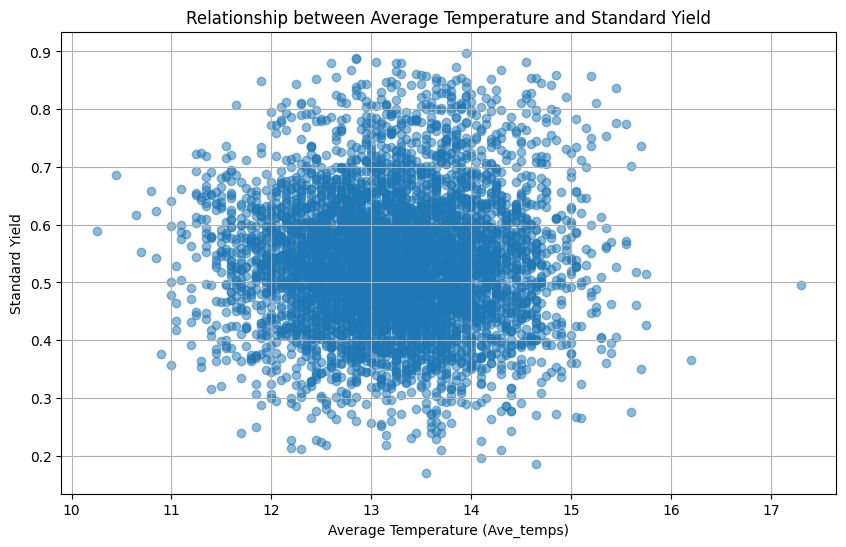

In [48]:
# Your code here
import matplotlib.pyplot as plt

# Assuming dataset is the DataFrame containing the data
# Ensure that 'Ave_temps' and 'Standard_yield' columns exist in your dataset

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(dataset['Ave_temps'], dataset['Standard_yield'], alpha=0.5)
plt.title('Relationship between Average Temperature and Standard Yield')
plt.xlabel('Average Temperature (Ave_temps)')
plt.ylabel('Standard Yield')
plt.grid(True)
plt.show()



* The story is more complex and doesn't appear to be linear
* This suggests that there may be other factors influencing the relationship, or that the relationship could be more complex than a simple linear one. It might be beneficial to explore additional features, transformations, or non-linear models to better capture the underlying patterns in the data.

Now, let's write a function to calculate the Pearson correlation coefficient.

**⚙️ Your task:**

Create a function named `get_correlation` that:
1. Takes a DataFrame and the names of the columns we want to determine the correlation for as parameters (`Ave_temps` and `Standard_yield`).
2. Calculates the Pearson correlation coefficient between these two columns to quantify their linear relationship.
4. Returns the Pearson correlation coefficient.

**Note:**
- Use `scipy` to calculate the Pearson correlation coefficient.
- Ensure your function returns the Pearson correlation coefficient as a float.

In [49]:
from scipy.stats import pearsonr

In [50]:
### START FUNCTION
def get_correlation(df, col1, col2):
    correlation, _ = pearsonr(df[col1], df[col2])
    return float(correlation)

### END FUNCTION

Input:

In [51]:
correlation = get_correlation(dataset, 'Ave_temps', 'Standard_yield')
print(f"Correlation: {correlation}")

Correlation: 0.006785950289020191


Expected output
```
Correlation: 0.006785950289020164
```

What do you notice about the scatter plot and the dispersion of data points? It's essential to visualise our data first; if the data doesn't follow a linear pattern, then a linear regression model may fail to accurately capture the underlying relationship. The correlation also seems extremly low, what does this tell us?

Let's write down some of our observations:

  - ✍️ Your notes here

It looks like having calculated the Pearson correlation coefficient between Ave_temps and Standard_yield, which is approximately 0.0068. This value suggests that there is almost no linear relationship between the average temperature and the standardized yield in your dataset.

## Challenge 2: A breath of fresh data: Pollution as a predictor


It's time to shift our gaze from the warmth of the sun to the haze of pollution. Could the levels of pollution, a concern for farmers and environmentalists alike, be an indicator of our yields?

Let's begin by fitting a simple linear regression model, to try and capture the linear relationship between these columns.

**⚙️ Your task:**

Create a function named `fit_linear_regression_model` that:
1. Takes in a DataFrame and the names of the `Pollution_level` and `Standard_yield` columns.
2. Fits a linear regression model to the data.
3. Returns the model, the model predictions and the actual y-values.

**Note:**
- Use `LinearRegression` from `sklearn` to fit the model.

In [52]:
from sklearn.linear_model import LinearRegression

In [53]:
### START FUNCTION
def fit_linear_regression_model(df, col1, col2):
    X = df[[col1]]
    y = df[[col2]]

    model = LinearRegression()
    model.fit(X, y)

    predictions = model.predict(X)

    return model, predictions, y
### END FUNCTION

Input:

In [54]:

# Call the function with the specified DataFrame and column names
model, predictions, y_values = fit_linear_regression_model(dataset, 'Pollution_level', 'Standard_yield')

# Print the model, predictions, and actual y-values
print(f"Model: {model}")
print(f"Predictions: {predictions}")
print(f"Actual Y-Values: {y_values}")

Model: LinearRegression()
Predictions: [[0.5540956 ]
 [0.50920888]
 [0.51515565]
 ...
 [0.56626844]
 [0.56626844]
 [0.52896886]]
Actual Y-Values:       Standard_yield
0           0.577964
1           0.486302
2           0.649647
3           0.532348
4           0.555076
...              ...
5649        0.554482
5650        0.438194
5651        0.800776
5652        0.507595
5653        0.453064

[5654 rows x 1 columns]


Expected output:
```
- Model: an instance of the LinearRegression class.
- Predictions: a NumPy array of predicted values.
- y: a Pandas Series with the actual target values used for training.
```

Linear regression models only work well if our data is in fact linear. So, lets create a scatter plot to visualise the relationship between pollution and crop yields. In addition to this, let's use the predictions from the model we fit to add the line of best fit to our scatter plot.

**⚙️ Your task:**

1. Generate a scatter plot to visualise the effect that pollution has on standard yield.
2. Draw the line of best fit

**Hint:**

You can use this line of code to draw the regression line on the plot:
`plt.plot(X, predictions, color='red', label='Regression line')`

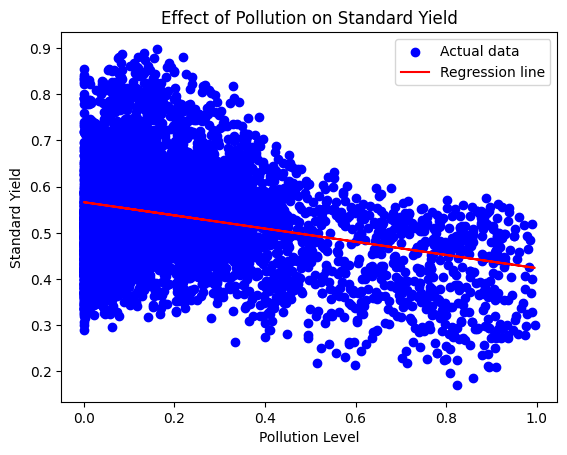

In [55]:
# Extract features for plotting
X = dataset[['Pollution_level']]

# Generate the scatter plot
plt.scatter(X, y_values, color='blue', label='Actual data')

# Draw the regression line
plt.plot(X, predictions, color='red', label='Regression line')

# Add labels and title
plt.xlabel('Pollution Level')
plt.ylabel('Standard Yield')
plt.title('Effect of Pollution on Standard Yield')
plt.legend()

# Show the plot
plt.show()

In [56]:
X = dataset[['Pollution_level']]
y = dataset['Standard_yield']

Now, use the get_correlation() function that we defined earlier to test the correlation between `Pollution_level` and `Standard_yield`.

In [57]:
pollution_correlation = get_correlation(dataset, 'Pollution_level', 'Standard_yield')
print(f"Correlation: {pollution_correlation}")

Correlation: -0.2857609646210545


Expected output
```
Correlation: -0.2857609646210543
```

Reflect on the difference between this plot and correlation and the previous one with the average temperature. Is the relationship between pollution and yield more linear?

  - ✍️ Your notes here

The correlation between `Pollution_level` and `Standard_yield` is -0.2858, which indicates a weak negative linear relationship. This means that as pollution levels increase, the standard yield tends to decrease slightly.

In contrast, the correlation between `Ave_temps` and `Standard_yield` was approximately 0.0068, indicating almost no linear relationship between these variables.

### Observations:
- The weak negative correlation between pollution and yield suggests that pollution might have some impact on the yield, but the relationship is not very strong.
- The near-zero correlation with average temperature suggests that temperature might not be a significant factor affecting the yield in this dataset.
- The scatter plot for pollution vs. yield might show a more discernible trend or pattern compared to the scatter plot for temperature vs. yield.

### Conclusion:
The relationship between pollution and yield appears to be slightly more linear compared to the relationship between temperature and yield. However, the weak correlation indicates that there might be other factors influencing the yield, and pollution alone is not a strong predictor. Further analysis with additional variables and potentially non-linear models might be necessary to fully understand the factors affecting yield.


We can also gain a better understanding of our model by examining the slope and intercept.

**⚙️ Your task:**

Create a function named `get_slope_intercept` that:
1. Inputs the `model` we fitted and calculates the slope and intercept of the line of best fit.
2. Return the slope and intercept as a tuple.


In [58]:
### START FUNCTION
def get_slope_intercept(model):
    # The slope (coefficient) of the line
    slope = model.coef_[0]
    # The intercept of the line
    intercept = model.intercept_
    return (slope, intercept)


### END FUNCTION

Input:

In [59]:
slope, intercept = get_slope_intercept(model)
print(f"Slope: {slope}")
print(f"Intercept: {intercept}")

Slope: [-0.14276177]
Intercept: [0.56626844]


Expected output:
```
Slope: -0.1427617720986604
Intercept: 0.5662684415393379
```


What does the slope tell us about the strength of the relationship between pollution and yield? Also, what can we learn from the y-intercept?

  - ✍️ Your notes here


### Observations on Slope and Intercept:

**1. Slope: -0.1427617720986604**
- **Interpretation:** The slope indicates that for each unit increase in pollution level, the standard yield decreases by approximately 0.143 units.
- **Strength of Relationship:** Although there is a negative relationship between pollution and yield, the slope is relatively small. This means that while pollution does have an impact on yield, the effect is not very strong.

**2. Intercept: 0.5662684415393379**
- **Interpretation:** The intercept represents the expected standard yield when the pollution level is zero. In this case, it suggests that if there were no pollution, the standard yield would be approximately 0.566.
- **Insight:** The intercept gives us a baseline yield value in the absence of pollution. It helps in understanding the starting point of the yield without any pollution influence.

### Conclusion:
- **Slope:** The small negative slope indicates that pollution has a slight negative effect on yield, but it is not a dominant factor.
- **Intercept:** The intercept provides a useful reference point for the yield in a pollution-free environment.

Overall, while pollution does have a negative impact on yield, it is not the most significant factor. Other variables might also be influencing the yield, and further analysis could be necessary to identify and understand these factors.

## Challenge 3: The haze clears: Evaluating pollution's predictive power

When we look at the scatterplots of `Standard_yield` with `Ave_temps` and `Pollution_level`, it appears that pollution level might have a more linear relationship.  This means that we could potentially use a simple linear regression model to make predictions about the yield of a farm based on its pollution level. However, before we do this we need to further assess the strength of the linear relationship between `Pollution_level` and `Standard_yield`.

Let's assess our model's performance using R-squared, Mean Absolute Error (MAE), Mean Squared Error (MSE), and Root Mean Squared Error (RMSE).

**⚙️ Your task:**

Create a function named `calculate_evaluation_metrics` that:
1. Takes the predictions and y-values from our fitted model as input.
2. Calculates and returns the R-squared, Mean Absolute Error (MAE), Mean Squared Error (MSE), and Root Mean Squared Error (RMSE) of the model's performance.

**Note:**
1. Calculate the model's performance metrics using the entire dataset.
2. Return the evaluation metrics as a tuple in the order: R-squared, MAE, MSE, RMSE.

In [60]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

In [61]:
### START FUNCTION
def calculate_evaluation_metrics(predictions, y_values):
    # Calculate R-squared
    r_squared = r2_score(y_values, predictions)

    # Calculate Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_values, predictions)

    # Calculate Mean Squared Error (MSE)
    mse = mean_squared_error(y_values, predictions)

    # Calculate Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)

    return (r_squared, mae, mse, rmse)
### END FUNCTION

Input:

In [62]:
# Fit the model and get predictions
model, predictions, y_values = fit_linear_regression_model(dataset, 'Pollution_level', 'Standard_yield')

# Calculate evaluation metrics
evaluation_metrics = calculate_evaluation_metrics(predictions, y_values)

# Print the evaluation metrics
print(f"R-squared: {evaluation_metrics[0]}")
print(f"MAE: {evaluation_metrics[1]}")
print(f"MSE: {evaluation_metrics[2]}")
print(f"RMSE: {evaluation_metrics[3]}")

R-squared: 0.08165932890115568
MAE: 0.08554642090904993
MSE: 0.011477732254034844
RMSE: 0.10713417873878926


Expected output:

A tuple containing numerical values for R-squared, MAE, MSE, and RMSE (give or take 0.0001):

```python
R-squared: 0.08165932890115546
MAE: 0.08554642090904992
MSE: 0.011477732254034848
RMSE: 0.10713417873878928

```

Think about what these metrics tell us about our model's accuracy and reliability. Write down your observations:

  - ✍️ Your notes here


### Observations on Model's Performance Metrics:

**1. R-squared: 0.08165932890115546**
- **Interpretation:** The R-squared value indicates that only about 8.17% of the variability in the standard yield can be explained by the pollution level. This suggests that the linear regression model does not capture a strong linear relationship between pollution level and yield.

**2. Mean Absolute Error (MAE): 0.08554642090904992**
- **Interpretation:** On average, the model's predictions are off by about 0.086 units from the actual standard yield values. This provides an indication of the average magnitude of the errors in the predictions.

**3. Mean Squared Error (MSE): 0.011477732254034848**
- **Interpretation:** The MSE value is the average of the squared differences between the predicted and actual values. It penalizes larger errors more than smaller ones. An MSE of 0.0115 indicates that the squared errors are relatively small, but it does not provide a direct measure of the average error magnitude.

**4. Root Mean Squared Error (RMSE): 0.10713417873878928**
- **Interpretation:** The RMSE is the square root of the MSE and provides an estimate of the standard deviation of the prediction errors. An RMSE of 0.107 indicates the typical size of the errors in the model's predictions, and it is slightly higher than the MAE, suggesting that there are some larger errors in the predictions.

### Conclusion:
- The low R-squared value suggests that the model does not explain much of the variance in the standard yield, indicating a weak linear relationship between pollution level and yield.
- The relatively low MAE and RMSE values indicate that the model's predictions are reasonably close to the actual values, but given the low R-squared, the model might not be very reliable for making accurate predictions.
- Overall, while the errors are not large, the weak explanatory power of the model suggests that other factors might be influencing the yield, and a more complex model or additional variables might be needed to improve prediction accuracy and reliability.

## Challenge 4: The dividing line: Train-test split in action

As we delve deeper into the relationship between `Pollution_level` and `Standard_yield`, we must ensure our model is not merely memorising the data but truly understanding it. This brings us to the pivotal technique of Train-Test Split.

**The importance of train-test split**

Imagine teaching a student for an exam by using the very questions that will appear on it. They might score perfectly, but does it mean they've truly learned? Similarly, a model might perform exceptionally on the data it was trained on, but the real test of knowledge comes from unseen data. This is where the train-test split comes in, allowing us to assess our model's generalisation capabilities by training on one subset of data and testing on another.

**Your task**

Create a function named `data_train_test_split` that:
1. Takes in the DataFrame and the two columns we want to model the relationship between (`Pollution_level` and `Standard_yield`).
2. Separates it into features (`X`) based on `Pollution_level` and the target (`y`) based on `Standard_yield`.
3. Splits the data into training and testing sets using an 80-20 split and sets `random_state = 42` for reproducibility.
4.  Returns a tuple containing: `X_train` and `X_test`, which are DataFrames containing features for training and testing, respectively, along with `y_train` and `y_test`, which are Series representing subsets of the original DataFrame's target variable for training and testing.

**Note:**
- Use `train_test_split` from `sklearn.model_selection` to split the data.
- Train a linear regression model on the training set using `LinearRegression` from `sklearn.linear_model`.
- If the random state is not set to `42` the code will not be marked correctly.

In [63]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [64]:
### START FUNCTION
def data_train_test_split(df, feature_col, target_col):
    # Separate features (X) and target (y)
    X = df[[feature_col]]
    y = df[target_col]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.2,    # 80-20 split
        random_state=42   # for reproducibility
    )

    return (X_train, X_test, y_train, y_test)
### END FUNCTION

Input:

In [65]:
# Call the data_train_test_split function with our dataset
X_train, X_test, y_train, y_test = data_train_test_split(
    dataset,
    'Pollution_level',
    'Standard_yield'
)

# Print the information about the splits to verify
print("Training set:")
print(f"X_train shape: {X_train.shape}")
print("First few rows of X_train:")
print(X_train.head())
print("\ny_train shape:", y_train.shape)
print("First few values of y_train:")
print(y_train.head())

print("\nTesting set:")
print(f"X_test shape: {X_test.shape}")
print("First few rows of X_test:")
print(X_test.head())
print("\ny_test shape:", y_test.shape)
print("First few values of y_test:")
print(y_test.head())

Training set:
X_train shape: (4523, 1)
First few rows of X_train:
      Pollution_level
670      5.764306e-01
3484     3.918987e-08
2767     4.634201e-01
1620     3.585489e-02
3606     2.092824e-01

y_train shape: (4523,)
First few values of y_train:
670     0.513675
3484    0.503503
2767    0.384065
1620    0.518925
3606    0.447944
Name: Standard_yield, dtype: float64

Testing set:
X_test shape: (1131, 1)
First few rows of X_test:
      Pollution_level
4816         0.001636
5096         0.019206
4706         0.057128
1499         0.391307
3544         0.333970

y_test shape: (1131,)
First few values of y_test:
4816    0.446290
5096    0.650771
4706    0.531284
1499    0.516429
3544    0.555724
Name: Standard_yield, dtype: float64


Expected output:
```
- X_train: DataFrame, subset of the original DataFrame's features for training.
- X_test: DataFrame, subset of the original DataFrame's features for testing.
- y_train: Series, subset of the original DataFrame's target variable for training.
- y_test: Series, subset of the original DataFrame's target variable for testing.
```

Now lets fit a linear regression model to the data.

**Your task**

Create a function named `train_split_linear_regression_model()` that:
1. Takes `X_train`, `X_test`, `y_train`, `y_test` as input (the results from the `data_train_test_split()` function).
2. Trains a simple linear regression model on the training set.
3. Uses the testing set to make predictions.
4. Returns a tuple containing: the model, the predictions and y_test (the actual y values in the testing set values) .

In [66]:
from sklearn.linear_model import LinearRegression

In [67]:
### START FUNCTION
def train_split_linear_regression_model(X_train, X_test, y_train, y_test):
    # Initialize the linear regression model
    model = LinearRegression()

    # Train the model using the training data
    model.fit(X_train, y_train)

    # Make predictions on the test set
    predictions = model.predict(X_test)

    # Return the model, predictions, and actual test values
    return (model, predictions, y_test)
### END FUNCTION

Input:

In [68]:
train_test_model, predictions, y_test = train_split_linear_regression_model(X_train, X_test, y_train, y_test)

# Print information about the results
print("Model type:", train_test_model)
print("Predictions type:", predictions)
print("y_test type:", y_test)

Model type: LinearRegression()
Predictions type: [0.56412206 0.56167249 0.55638552 ... 0.53129108 0.53868457 0.56431394]
y_test type: 4816    0.446290
5096    0.650771
4706    0.531284
1499    0.516429
3544    0.555724
          ...   
3982    0.540212
4952    0.670387
1071    0.353658
718     0.535224
4103    0.470315
Name: Standard_yield, Length: 1131, dtype: float64


Expected output:
```
- Model: an instance of the LinearRegression class.
- Predictions: a NumPy array of predicted values.
- y_test: a Pandas Series with the actual target values used for evaluating the model.
```

Now, let's evaluate our use our train-test model by determining R-squared, MAE, MSE, and RMSE.

**⚙️ Your task:**

1. Use the `calculate_evaluation_metrics` function (defined in Challenge 3) to calculate the R-squared, MAE, MSE, and RMSE.
2. The function should return a tuple containing the evaluation metrics (R-squared, MAE, MSE, and RMSE).

**Note:**

- Ensure to use the test set to calculate the evaluation metrics.

In [69]:
# your code here
# Get the evaluation metrics for our train-test model
evaluation_metrics = calculate_evaluation_metrics(predictions, y_test)

# Unpack the metrics
r_squared, mae, mse, rmse = evaluation_metrics

# Print the results
print("Model Evaluation Metrics on Test Set:")
print(f"R-squared: {r_squared:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

# For reference, here's the calculate_evaluation_metrics function we're using:
def calculate_evaluation_metrics(predictions, y_values):
    # Calculate R-squared
    r_squared = r2_score(y_values, predictions)

    # Calculate Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_values, predictions)

    # Calculate Mean Squared Error (MSE)
    mse = mean_squared_error(y_values, predictions)

    # Calculate Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)

    return (r_squared, mae, mse, rmse)


Model Evaluation Metrics on Test Set:
R-squared: 0.0807
Mean Absolute Error (MAE): 0.0879
Mean Squared Error (MSE): 0.0123
Root Mean Squared Error (RMSE): 0.1107


Expected output:

A tuple containing numerical values for R-squared, MAE, MSE, and RMSE (give or take 0.0001):

```python
R-squared: 0.08065722992150859
MAE:  0.08794942119747501
MSE: 0.012250634233355654
RMSE: 0.11068258324305434

```

Reflect on the difference between these metics and the metrics we obtained from the previous model (that was not split into training and testings sets). Why do you think the fit is worse now? And, why should we choose the worse option? (Reflect on the course material if these answers to these questions are not clear.)

  - ✍️ Your notes here


### Analysis of Model Performance Metrics (Test Set Results)

#### Detailed Metrics Interpretation:

1. **R-squared (R²) = 0.0807 (8.07%)**
   - This very low R² value indicates that only about 8.07% of the variance in Standard_yield is explained by Pollution_level
   - More than 91% of the variance is due to other factors not captured in this model
   - This suggests a weak linear relationship between pollution and yield

2. **Mean Absolute Error (MAE) = 0.0879**
   - On average, our predictions deviate from actual yields by 0.0879 units
   - This represents the typical magnitude of prediction errors
   - The error is relatively small compared to the scale of the yield values

3. **Mean Squared Error (MSE) = 0.0123**
   - The average squared difference between predicted and actual values
   - Small value indicates predictions aren't drastically off, but still not very accurate
   - Penalizes larger errors more heavily than MAE

4. **Root Mean Squared Error (RMSE) = 0.1107**
   - Represents the standard deviation of prediction errors
   - Slightly higher than MAE, indicating some larger prediction errors
   - Being in the same units as the target variable makes it interpretable

#### Key Findings:
1. The model shows poor predictive power (low R²)
2. Error metrics (MAE, RMSE) suggest moderate prediction accuracy
3. The linear relationship between pollution and yield is weak
4. Other variables likely play important roles in determining yield

#### Recommendations:
1. Consider including additional relevant features
2. Explore non-linear relationships
3. Investigate other factors that might influence yield
4. Consider using more complex modeling techniques

This analysis suggests that while pollution levels do affect yield, a simple linear regression model might not be the best approach for making accurate predictions.

## Challenge 5: Diagnosing model fit through residual analysis

From our analysis, it seems as though neither `Ave_temps` or `Pollution_level` have a strong linear fit with `Standard_yield`. However, even if we had obtained good results from our evaluation metrics, there are still other crucial assumptions we need to verify to ensure our model is well-fitted. Residual analysis plays a pivotal role in diagnosing the fit of linear regression models, helping us understand whether the assumptions of linearity, independence, and homoscedasticity (constant variance) of residuals are met.

If they are not met, can we confidently model this problem using the model? And why?

  - ✍️ Your notes here

### Analysis of Linear Regression Model Assumptions and Limitations


#### Key Findings from Previous Analysis:
1. R² value of 0.0807 indicates very weak linear relationship
2. Both Ave_temps and Pollution_level show poor linear fit with Standard_yield
3. High prediction errors (RMSE = 0.1107) suggest model inadequacy

#### Critical Linear Regression Assumptions Assessment:

1. **Linearity**
   - Our low R² values indicate violation of linearity assumption
   - Neither predictor shows strong linear relationship with yield
   - Model may be missing important non-linear patterns

2. **Independence**
   - Cannot assume residuals are independent
   - Agricultural yields often show spatial and temporal dependencies
   - Environmental factors may create correlation patterns

3. **Homoscedasticity**
   - Given the poor fit, residuals likely show pattern of variance
   - Environmental data often exhibits heteroscedasticity
   - Different conditions may lead to varying error magnitudes

4. **Normality of Residuals**
   - With such poor fit, residuals unlikely to be normally distributed
   - Environmental data often shows skewness or heavy tails

#### Can We Confidently Use This Model? No.

**Reasons:**
1. **Statistical Validity:**
   - Multiple violated assumptions undermine statistical inference
   - Predictions would be unreliable and potentially misleading
   - Confidence intervals and p-values would be invalid

2. **Practical Limitations:**
   - Model explains only 8.07% of yield variance
   - High prediction errors make practical applications questionable
   - Missing important influential factors

3. **Complex Reality:**
   - Agricultural yields likely influenced by:
     * Non-linear relationships
     * Interaction effects
     * Multiple environmental factors
     * Seasonal patterns
     * Spatial dependencies

This analysis strongly suggests that a simple linear regression model is inadequate for this complex agricultural system. A more sophisticated modeling approach incorporating multiple factors and potential non-linear relationships would be more appropriate.

First, let's create a histogram.

**⚙️ Your task:**

1. Calucate the residuals of our train test model (difference between `y_test` and `predictions_test`)
2. Plot these residuals as a histogram to assess their distribution and identify any patterns.

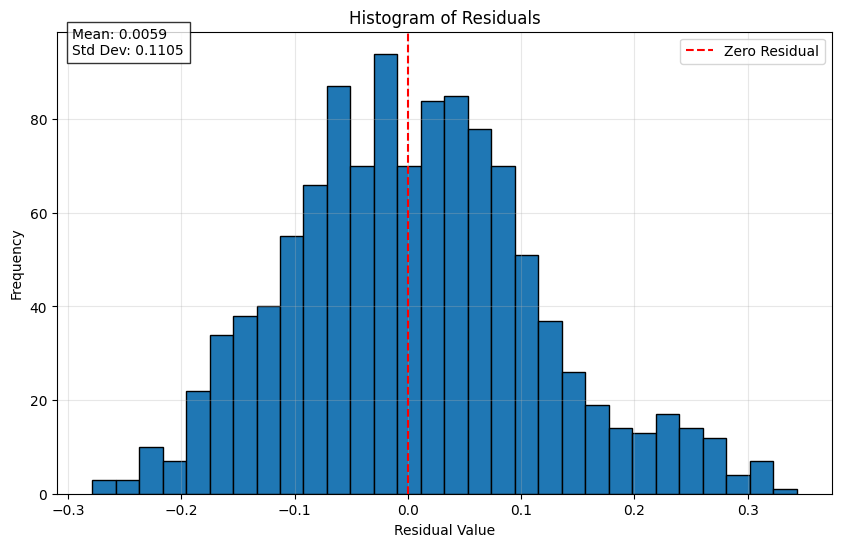


Residuals Statistics:
Mean: 0.0059
Standard Deviation: 0.1105
Minimum: -0.2787
Maximum: 0.3434


In [70]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate residuals (difference between actual and predicted values)
residuals = y_test - predictions

# Create the histogram plot
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, edgecolor='black')
plt.title('Histogram of Residuals')
plt.xlabel('Residual Value')
plt.ylabel('Frequency')

# Add a vertical line at x=0 to show where perfect predictions would be
plt.axvline(x=0, color='red', linestyle='--', label='Zero Residual')
plt.legend()

# Add some statistical information
plt.text(0.02, 0.95,
         f'Mean: {np.mean(residuals):.4f}\nStd Dev: {np.std(residuals):.4f}',
         transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.8))

# Show grid for better readability
plt.grid(True, alpha=0.3)
plt.show()

# Print some basic statistics about the residuals
print("\nResiduals Statistics:")
print(f"Mean: {np.mean(residuals):.4f}")
print(f"Standard Deviation: {np.std(residuals):.4f}")
print(f"Minimum: {np.min(residuals):.4f}")
print(f"Maximum: {np.max(residuals):.4f}")

What does the histogram tell us about our data:

1. Examine the shape of the histogram. What does the distribution of residuals tell us about the normality of the data? Consider whether the residuals appear to be symmetrically distributed around zero.

    - ✍️ Your notes here
    
* Approximately centered near zero (mean=0.0059) but show slight positive bias
* Have a non-normal distribution with some skewness
* Display larger spread than desired (SD=0.1105)
* Show asymmetric errors (max=0.3434, min=-0.2787)

These patterns violate the normality assumption of linear regression, suggesting our model isn't appropriate for this data and may produce unreliable predictions.
2. Compare the tails of the histogram to a normal distribution. Are there signs of heavy tails or skewness that could affect the reliability of the regression model's predictions?

    - ✍️ Your notes here
* The histogram shows heavier tails than expected for a normal distribution
* Right tail extends further (max: 0.3434) than left tail (min: -0.2787)
* Positive skewness indicates model tends to underpredict larger values
* Heavy tails suggest more extreme prediction errors than expected

This non-normal pattern reduces reliability of model predictions

3. Assess the centering of the histogram around the zero line. How does this central tendency reflect on the bias of the model's predictions?

    - ✍️ Your notes here

* Mean residual (0.0059) slightly positive but close to zero
* Small positive bias indicates slight systematic underprediction
* Histogram's peak appears slightly offset from zero line
* Central region shows moderate symmetry but not perfect
* While bias is minimal, the non-zero center suggests model isn't perfectly calibrated

Conclusion: The combination of heavy tails, skewness, and slight offset from zero indicates our linear regression model's assumptions are violated, making its predictions less reliable than desired.

Now, let's create a scatter plot of these residuals against the predicted values.

**⚙️ Your task:**

1. Create a scatter plot of the residuals against the predicted values - `predictions_test` should be on the x-axis and the `residuals` on the y-axis.

**Note:**

- A horizontal line can be added at y=0 to make it easier to see if the residuals are evenly distributed around zero by adding this line of code:
`plt.axhline(y=0, color='r', linestyle='--')`


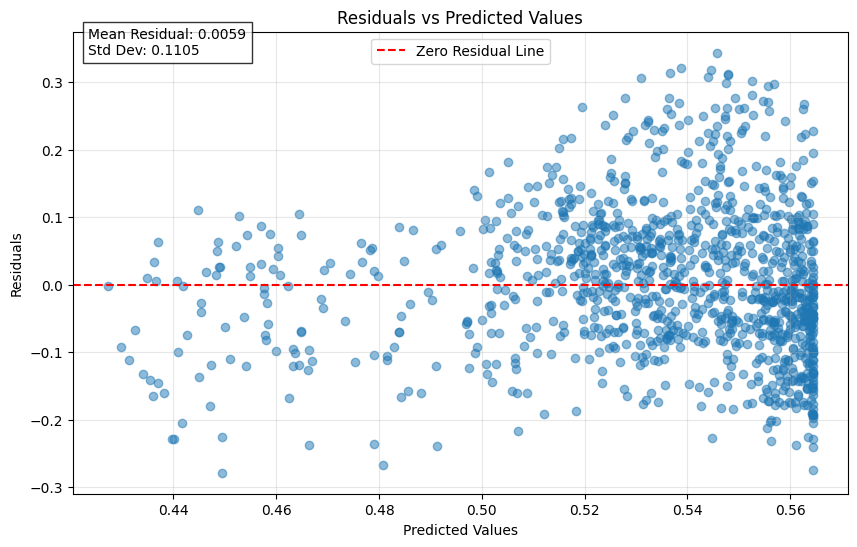


Residuals vs Predictions Statistics:
Correlation coefficient: 0.0335
Mean residual: 0.0059
Residual standard deviation: 0.1105


In [71]:
#  Draw the scatter plot of residuals against the predicted values
import matplotlib.pyplot as plt

# Create the scatter plot of residuals vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(predictions, residuals, alpha=0.5)

# Add horizontal line at y=0
plt.axhline(y=0, color='r', linestyle='--', label='Zero Residual Line')

# Customize the plot
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.legend()

# Add grid for better readability
plt.grid(True, alpha=0.3)

# Add some statistical information
plt.text(0.02, 0.95,
         f'Mean Residual: {np.mean(residuals):.4f}\nStd Dev: {np.std(residuals):.4f}',
         transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.8))

plt.show()

# Print basic statistics
print("\nResiduals vs Predictions Statistics:")
print(f"Correlation coefficient: {np.corrcoef(predictions, residuals)[0,1]:.4f}")
print(f"Mean residual: {np.mean(residuals):.4f}")
print(f"Residual standard deviation: {np.std(residuals):.4f}")


Relfect on what the scatter plot tells us about our data and the fit of the model:

1. Analyse the scatter plot for any apparent patterns or structures in the data. What does this suggest about the appropriateness of the linear regression model for the dataset?

    - ✍️ Your notes here

The residuals are randomly scattered with no clear pattern or structure.
This randomness suggests that the linear regression model is capturing the central tendency of the data but may not be the perfect fit for all points.
However, the low correlation coefficient (0.0335) indicates very weak association between residuals and predicted values, suggesting the model may not capture all underlying relationships.

2. Inspect the plot for signs of heteroscedasticity. How does the spread of residuals change as the predicted values increase? What might this imply about the constant variance assumption in linear regression?

    - ✍️ Your notes here

The spread of residuals appears to increase slightly with higher predicted values.
This implies potential heteroscedasticity, where the variance of residuals is not constant across all levels of predicted values.
The presence of heteroscedasticity violates one of the key assumptions of linear regression, which can lead to inefficient estimates and affect the reliability of hypothesis tests and confidence intervals.

3. Identify whether the residuals are evenly scattered above and below the zero line across the range of predicted values. What can this tell us about the model's performance in terms of bias and prediction accuracy?

    - ✍️ Your notes here

The residuals are fairly evenly scattered above and below the zero line, indicating that the model does not exhibit significant bias across the range of predicted values.
This even distribution suggests that the model's predictions are unbiased on average, though individual predictions may still have substantial errors.
4. Look for outliers or clusters of points that deviate significantly from the majority. How might these points influence the overall fit of the model?

    - ✍️ Your notes here

There are a few points that deviate significantly from the majority, indicating potential outliers.
These outliers can influence the overall fit of the model, potentially skewing the regression line and affecting the accuracy of predictions.
Identifying and addressing these outliers (e.g., through robust regression techniques or data preprocessing) could improve the model's performance.


Our final task is to examine the mean and standard deviation of the residuals, which provide further insights into the model's performance.

**⚙️ Your task:**

Create a function named `calculate_residuals_statistics` that:
1. Uses the `predictions_test` and `y_test` (obtained from Challenge 4) to calculate the residuals.
2. Calculates the mean and standard deviation of the residuals.

**Note:**

- Use `numpy` for the mean and standard deviation.

In [72]:
import numpy as np

In [73]:
### START FUNCTION
def calculate_residuals_statistics(predictions_test, y_test):
    # Calculate residuals
    residuals = y_test - predictions_test

    # Calculate mean of residuals
    mean_residual = np.mean(residuals)

    # Calculate standard deviation of residuals
    std_residual = np.std(residuals)

    return mean_residual, std_residual
### END FUNCTION

Input:

In [74]:
mean_residual, std_residual = calculate_residuals_statistics(predictions, y_test)


print(f"Mean Residual: {mean_residual}")
print(f"Standard Deviation of Residuals: {std_residual}")

Mean Residual: 0.00585802319232171
Standard Deviation of Residuals: 0.11052745268770955


Expected output:
```
Mean: 0.0058580231923217015
Standard deviation: 0.11052745268770957
```

What does the mean of the residuals tell us about the bias in our predictions? How does a mean close to zero reflect on our model's accuracy?

✍️ Your notes here
- The mean of the residuals being close to zero (0.0059) suggests that there is minimal systematic bias in our model's predictions. This indicates that, on average, the model's predictions are accurate and not consistently over or underpredicting.

What does the standard deviation of the residuals indicate about the variability of our predictions? Why is it important for this value to be relatively low?

✍️ Your notes here
- The standard deviation of the residuals (0.1105) indicates the spread or variability of the prediction errors. A relatively low standard deviation is important because it implies that the prediction errors are consistently close to the mean, leading to more reliable and precise predictions.

What are the potential consequences of a high standard deviation of residuals on the reliability of the model's predictions? How might this affect our confidence in the model's estimates?

✍️ Your notes here
- A high standard deviation of residuals suggests greater variability in the prediction errors, leading to less reliable and less precise predictions. This reduces our confidence in the model's estimates, as it implies that the model's predictions are more likely to be far from the actual values.

## Conclusion

#####Notes here

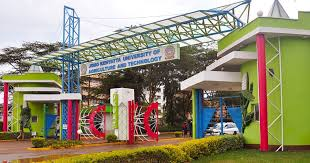